In [1]:
!git clone https://github.com/egemenokte/3DLayeredElastic.git
%cd 3DLayeredElastic/Run
import sys
import os
sys.path.append('..')
from Main.MLEV_Parallel import PyMastic
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
import random
import sys
import os

fatal: destination path '3DLayeredElastic' already exists and is not an empty directory.
/home/ugiridharan_umass_edu/3DLayeredElastic/Run


/home/ugiridharan_umass_edu/.local/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import pickle
import torch
import json
import time
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,mean_absolute_error
import torch
import matplotlib.pyplot as plt
import numpy as np
import logging
import os
import seaborn as sns
import torch.nn as nn
import copy
from torch import nn

from torch.nn import Linear, ReLU,Tanh
from torch_geometric.nn import GCNConv, GATConv
import torch.nn.functional as F

In [3]:
import pickle
with open('/home/ugiridharan_umass_edu/GNN_training/batched_graph_test.pkl', 'rb') as fp:
    batched_graph_test = pickle.load(fp)

In [4]:

class GAT(torch.nn.Module):
    def __init__(self,input_dim,hidden_dim1, hidden_dim, output_dim, num_layers,):
        super(GAT,self).__init__()
        torch.manual_seed(1234)
        self.convs = None
        def get_in_channels(idx):
            if idx>1:
                return hidden_dim
            elif idx==1:
                return hidden_dim1
            else:
                return input_dim 

        def get_out_channels(idx):
            if idx==0:
                return hidden_dim1
            elif idx>0 and idx<=num_layers-1:
                return hidden_dim
            else:
                return output_dim
        self.convs = torch.nn.ModuleList([
              GATConv(in_channels=get_in_channels(i), out_channels=get_out_channels(i))
              for i in range(num_layers)
          ])

        self.batch_norms = torch.nn.ModuleList([nn.BatchNorm1d(get_out_channels(i)) for i in range(num_layers)])
        self.linear1 = torch.nn.Linear(hidden_dim,hidden_dim)
        self.linear = torch.nn.Linear(hidden_dim, output_dim)
    def forward(self, x, edge_index):
    
        for i, (gat,batch_norm) in enumerate(zip(self.convs,self.batch_norms)):
            x = gat(x, edge_index)
            x = batch_norm(x)
            x = F.relu(x)
        x=self.linear1(x)
        x=F.relu(x)
        x=self.linear1(x)
        x = F.relu(x)
        out = self.linear(x)
        return out


In [5]:
input_dim =5
hidden_dim1=128
hidden_dim=90
output_dim=3
num_layers=10


In [6]:
path = '/work/pi_eokte_umass_edu/Urja/NEW_MODEL/z_strain_dropped_1500/6_neighbour_with_linear/denorm/0/checkpoints/model_epoch_14700.pt'
checkpoint = torch.load(path)
model = GAT(input_dim, hidden_dim1, hidden_dim, output_dim, num_layers)

model_state_dict = checkpoint['model_state_dict']
# print(model_state_dict.keys())
model.load_state_dict(model_state_dict)  
model.eval()  # Set the model to evaluation mode
  

    

/tmp/ipykernel_789047/1938091292.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


GAT(
  (convs): ModuleList(
    (0): GATConv(5, 128, heads=1)
    (1): GATConv(128, 90, heads=1)
    (2-9): 8 x GATConv(90, 90, heads=1)
  )
  (batch_norms): ModuleList(
    (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1-9): 9 x BatchNorm1d(90, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear1): Linear(in_features=90, out_features=90, bias=True)
  (linear): Linear(in_features=90, out_features=3, bias=True)
)

In [7]:
with torch.no_grad():
    batched_graph_test = batched_graph_test.cpu()
    model=model.cpu()
    test_outputs = model(batched_graph_test.x,batched_graph_test.edge_index)

predicted_values = test_outputs.numpy()




In [8]:
mse_z = mean_squared_error( batched_graph_test.y[:, 0].cpu().detach().numpy(), predicted_values[:, 0])
mse_r = mean_squared_error( batched_graph_test.y[:, 1].cpu().detach().numpy(), predicted_values[:, 1])
mse_t = mean_squared_error( batched_graph_test.y[:, 2].cpu().detach().numpy(), predicted_values[:, 2])
mae_z = mean_absolute_error( batched_graph_test.y[:, 0].cpu().detach().numpy(), predicted_values[:, 0])
mae_r = mean_absolute_error(batched_graph_test.y[:, 1].cpu().detach().numpy(), predicted_values[:, 1])
mae_t = mean_absolute_error(batched_graph_test.y[:, 2].cpu().detach().numpy(), predicted_values[:, 2])

mape_z = mean_absolute_percentage_error(batched_graph_test.y[:, 0].cpu().detach().numpy(), predicted_values[:, 0])
mape_r = mean_absolute_percentage_error(batched_graph_test.y[:, 1].cpu().detach().numpy(), predicted_values[:, 1])
mape_t = mean_absolute_percentage_error(batched_graph_test.y[:, 2].cpu().detach().numpy(), predicted_values[:, 2])


In [9]:
print(mae_z ,mae_r ,mae_t)

1.7598145008087158 0.7835447192192078 0.7724578380584717


In [10]:
train_losses=checkpoint['train_loss_history']
val_losses=checkpoint['val_loss_history']

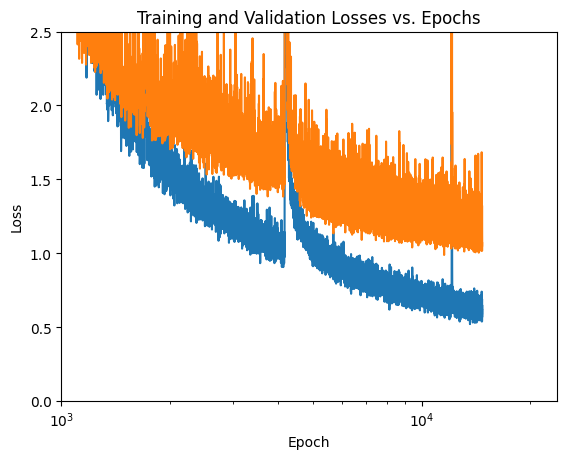

In [11]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xscale('log')
plt.xlim(left=1000)
plt.ylim(top=2.5,bottom=0)
plt.title('Training and Validation Losses vs. Epochs')
plt.show()
plt.close() 

<>:27: SyntaxWarning: invalid escape sequence '\m'
<>:28: SyntaxWarning: invalid escape sequence '\m'
<>:29: SyntaxWarning: invalid escape sequence '\m'
<>:27: SyntaxWarning: invalid escape sequence '\m'
<>:28: SyntaxWarning: invalid escape sequence '\m'
<>:29: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_844332/1780267308.py:27: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('Actual $\mu\epsilon$', fontsize=12)
/tmp/ipykernel_844332/1780267308.py:28: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Predicted $\mu\epsilon$', fontsize=12)
/tmp/ipykernel_844332/1780267308.py:29: SyntaxWarning: invalid escape sequence '\m'
  plt.title('Actual vs Predicted in $\mu\epsilon_r$ and $\mu\epsilon_t$', fontsize=12)


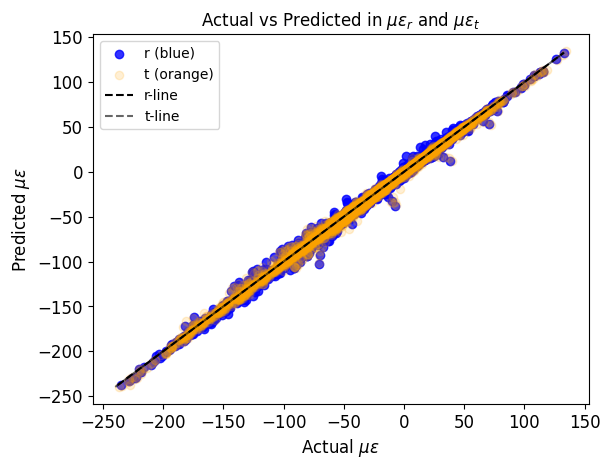

In [15]:
import matplotlib.pyplot as plt
import os

# Extract actual and predicted values for r and t
stress_r = batched_graph_test.y[:, 1]
stress_t = batched_graph_test.y[:, 2]

pred_r = predicted_values[:, 1]
pred_t = predicted_values[:, 2]

# Create scatter plots for r and t with transparency
plt.scatter(stress_r, pred_r, label="r (blue)", color='blue',alpha=0.8)
plt.scatter(stress_t, pred_t, label="t (orange)", color='orange', alpha=0.17)

# Determine the range for plot lines
p1_r = max(max(stress_r), max(pred_r))
p2_r = min(min(stress_r), min(pred_r))

p1_t = max(max(stress_t), max(pred_t))
p2_t = min(min(stress_t), min(pred_t))

# Plot diagonal lines for both r and t (black dashed lines)
plt.plot([p2_r, p1_r], [p2_r, p1_r], color='black', linestyle='--', label="r-line")
plt.plot([p2_t, p1_t], [p2_t, p1_t], color='black', linestyle='--', alpha=0.6, label="t-line")

# Labels and titles
plt.xlabel('Actual $\mu\epsilon$', fontsize=12)
plt.ylabel('Predicted $\mu\epsilon$', fontsize=12)
plt.title('Actual vs Predicted in $\mu\epsilon_r$ and $\mu\epsilon_t$', fontsize=12)

# Set tick parameters with font size 12 pt
plt.tick_params(axis='both', which='major', labelsize=12)

# Add legend
plt.legend()
plt.show()
plt.close()


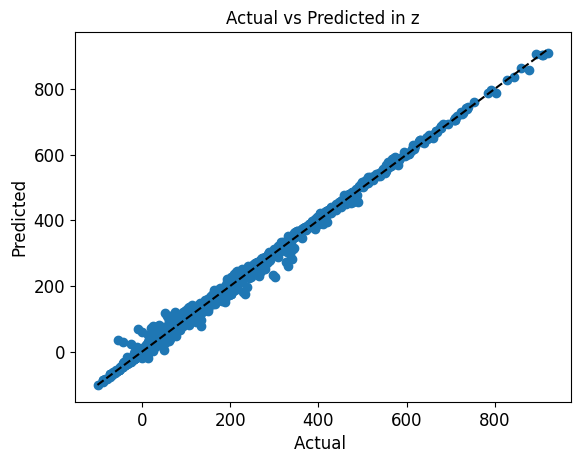

In [12]:

Strain_z = batched_graph_test.y[:,0].cpu().detach().numpy()
plt.scatter(Strain_z, predicted_values[:,0])
p1= max(max(predicted_values[:,0]), max(Strain_z))
p2=min(min(predicted_values[:,0]), min(Strain_z))
plt.plot([p2,p1],[p2,p1],color='black', linestyle='--')
plt.xlabel('Actual ', fontsize=12)
plt.ylabel('Predicted', fontsize=12)
plt.title('Actual vs Predicted in z', fontsize=12)

# Set tick parameters with font size 12 pt
plt.tick_params(axis='both', which='major', labelsize=12)

In [17]:
sns.set_style("darkgrid")

plot_dir='/home/ugiridharan_umass_edu/GNN_training'
stress_z = batched_graph_test.y[:,0]

plt.scatter(stress_z, predicted_values[:,0])
p1= max(max(stress_z), max(stress_z))
p2=min(min(stress_z), min(stress_z))
plt.plot([p2,p1],[p2,p1],color='black', linestyle='--')
plt.xlabel('Actual $\mu\epsilon_z$', fontsize=12)
plt.ylabel('Predicted $\mu\epsilon_z$', fontsize=12)
plt.title('Actual vs Predicted in $\mu\epsilon_z$', fontsize=12)

# Set tick parameters with font size 12 pt
plt.tick_params(axis='both', which='major', labelsize=12)
plt.savefig(os.path.join(plot_dir, f"GNNinset_strain_z.png"))
plt.close() 

stress_r = batched_graph_test.y[:,1]
plt.scatter(stress_r, predicted_values[:,1])
p1= max(max(stress_r), max(stress_r))
p2=min(min(stress_r), min(stress_r))
plt.plot([p2,p1],[p2,p1],color='black', linestyle='--')
plt.xlabel('Actual $\mu\epsilon_r$', fontsize=12)
plt.ylabel('Predicted $\mu\epsilon_r$', fontsize=12)
plt.title('Actual vs Predicted in $\mu\epsilon_r$', fontsize=12)

# Set tick parameters with font size 12 pt
plt.tick_params(axis='both', which='major', labelsize=12)
plt.savefig(os.path.join(plot_dir, f"GNNinset_strain_r.png"))
plt.close() 

stress_t = batched_graph_test.y[:,2]
plt.scatter(stress_t, predicted_values[:,2])
p1= max(max(stress_t), max(stress_t))
p2=min(min(stress_t), min(stress_t))
plt.plot([p2,p1],[p2,p1],color='black', linestyle='--')
plt.xlabel('Actual $\mu\epsilon_t$', fontsize=12)
plt.ylabel('Predicted $\mu\epsilon_t$', fontsize=12)
plt.title('Actual vs Predicted in $\mu\epsilon_t$', fontsize=12)

# Set tick parameters with font size 12 pt
plt.tick_params(axis='both', which='major', labelsize=12)
plt.savefig(os.path.join(plot_dir, f"GNNinset_strain_t.png"))
plt.close() 

<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:26: SyntaxWarning: invalid escape sequence '\m'
<>:38: SyntaxWarning: invalid escape sequence '\m'
<>:39: SyntaxWarning: invalid escape sequence '\m'
<>:40: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:26: SyntaxWarning: invalid escape sequence '\m'
<>:38: SyntaxWarning: invalid escape sequence '\m'
<>:39: SyntaxWarning: invalid escape sequence '\m'
<>:40: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_844332/1978060688.py:10: SyntaxWarning: invalid escape sequence '\m

In [53]:
pred_graph ={}
current_index = 0
for i in range(batched_graph_test.batch_size):
    res_test= len(batched_graph_test[i].y)
    
    pred_values = predicted_values[current_index:current_index+res_test]
    
    pred_graph[i]=pred_values
    current_index+=res_test
    
    

Change the number of test_struct and test_g_struct to generate the evaluation for different structures in test set

In [65]:
test_struct=4
test_g_struct=4

In [66]:

with open('/home/ugiridharan_umass_edu/GNN_training/ZS_test', 'rb') as fp:
    ZS_new = pickle.load(fp)

In [67]:
ZS_converted = [i*2.54 for i in ZS_new]

In [68]:
len(ZS_converted)

90

In [69]:

with open('/home/ugiridharan_umass_edu/GNN_training/xs', 'rb') as fp:
    xs = pickle.load(fp)

In [70]:
xs

array([ 0.5       ,  0.96021096,  1.56925807,  2.32714132,  3.23386073,
        4.28941629,  5.49380799,  6.84703584,  8.34909985, 10.        ])

To convert to SI units

In [71]:
xs_converted= xs*2.54

In [72]:
xs_converted

array([ 1.27      ,  2.43893583,  3.98591549,  5.91093896,  8.21400625,
       10.89511736, 13.95427229, 17.39147104, 21.20671361, 25.4       ])

In [73]:
# Read dictionary pkl file
with open('/work/pi_eokte_umass_edu/Urja/Frame_data_1000_new_modified.pkl', 'rb') as fp:
    FrameLarge = pickle.load(fp)
with open('/work/pi_eokte_umass_edu/Urja/Section_data_1000_new_modified.pkl', 'rb') as fp:
    Section = pickle.load(fp)

In [74]:
xs=np.round(xs_converted,2)
ZS_new=[np.round(zs,2) for zs in ZS_converted]

In [50]:
plot_dir='/home/ugiridharan_umass_edu/GNN_training/results_gnnstrains'

sns.set(rc={'figure.figsize':(20,10)},font_scale=3)
z=np.array(ZS_new[test_struct])
response='Strain_Z'
A_prep=np.reshape(batched_graph_test[test_g_struct].y[:,0],(len(ZS_new[test_struct]),len(xs)))
heatmap = sns.heatmap(A_prep, linewidths=.5,xticklabels=xs,yticklabels=-z,  # Annotation font size
            cbar_kws={'label': 'Strain (µε)'})  # Colorbar label font size
colorbar = heatmap.collections[0].colorbar
colorbar.ax.yaxis.label.set_size(30) 
plt.xlabel('x (cm)', fontsize=30)  # X-axis label font size
plt.ylabel('z (cm)', fontsize=30)  # Y-axis label font size
plt.title('$\epsilon_z$')
plt.xticks(fontsize=30)  # X-axis ticks font size
plt.yticks(fontsize=30)
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, f"GNN_strain_z_heatmap_struct0_orig.png"))
plt.close() 


sns.set(rc={'figure.figsize':(20,10)},font_scale=3)
z=np.array(ZS_new[test_struct])
response='Strain_Z'
A_bar=np.reshape(pred_graph[test_struct][:,0],(len(ZS_new[test_struct]),len(xs)))
heatmap = sns.heatmap(A_bar, linewidths=.5,xticklabels=xs,yticklabels=-z,   # Annotation font size
            cbar_kws={'label': 'Strain (µε)'})  # Colorbar label font size
colorbar = heatmap.collections[0].colorbar
colorbar.ax.yaxis.label.set_size(30) 
plt.xlabel('x (cm)', fontsize=30)  # X-axis label font size
plt.ylabel('z (cm)', fontsize=30)  # Y-axis label font size
plt.title(response)
plt.xticks(fontsize=30)  # X-axis ticks font size
plt.yticks(fontsize=30) 
plt.title('$\epsilon_z$')
plt.tight_layout()

plt.savefig(os.path.join(plot_dir, f"GNN_strain_z_heatmap_struct0_pred.png"))
plt.close() 


<>:13: SyntaxWarning: invalid escape sequence '\e'
<>:34: SyntaxWarning: invalid escape sequence '\e'
<>:13: SyntaxWarning: invalid escape sequence '\e'
<>:34: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_789047/3081027478.py:13: SyntaxWarning: invalid escape sequence '\e'
  plt.title('$\epsilon_z$')
/tmp/ipykernel_789047/3081027478.py:34: SyntaxWarning: invalid escape sequence '\e'
  plt.title('$\epsilon_z$')


In [75]:

plot_dir='/home/ugiridharan_umass_edu/GNN_training/results_gnnstrains'

sns.set(rc={'figure.figsize':(20,10)},font_scale=3)
z=np.array(ZS_new[test_struct])
response='Strain_Z'
A_prep=np.reshape(batched_graph_test[test_g_struct].y[:,0],(len(ZS_new[test_struct]),len(xs)))
heatmap = sns.heatmap(A_prep, linewidths=.5,xticklabels=xs,yticklabels=-z,  # Annotation font size
            cbar_kws={'label': 'Strain (µε)'})  # Colorbar label font size
colorbar = heatmap.collections[0].colorbar
colorbar.ax.yaxis.label.set_size(30) 
plt.xlabel('x (cm)', fontsize=30)  # X-axis label font size
plt.ylabel('z (cm)', fontsize=30)  # Y-axis label font size
plt.title('$\epsilon_z$')
plt.xticks(fontsize=30)  # X-axis ticks font size
plt.yticks(fontsize=30)
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, f"GNN_strain_z_heatmap_struct4_orig.png"))
plt.close() 


sns.set(rc={'figure.figsize':(20,10)},font_scale=3)
z=np.array(ZS_new[test_struct])
response='Strain_Z'
A_bar=np.reshape(pred_graph[test_struct][:,0],(len(ZS_new[test_struct]),len(xs)))
heatmap = sns.heatmap(A_bar, linewidths=.5,xticklabels=xs,yticklabels=-z,   # Annotation font size
            cbar_kws={'label': 'Strain (µε)'})  # Colorbar label font size
colorbar = heatmap.collections[0].colorbar
colorbar.ax.yaxis.label.set_size(30) 
plt.xlabel('x (cm)', fontsize=30)  # X-axis label font size
plt.ylabel('z (cm)', fontsize=30)  # Y-axis label font size
plt.title(response)
plt.xticks(fontsize=30)  # X-axis ticks font size
plt.yticks(fontsize=30) 
plt.title('$\epsilon_z$')
plt.tight_layout()

plt.savefig(os.path.join(plot_dir, f"GNN_strain_z_heatmap_struct4_pred.png"))
plt.close() 


 

sns.set(rc={'figure.figsize':(20,10)},font_scale=3)
z=np.array(ZS_new[test_struct])
response='Strain_R'
A_prep=np.reshape(batched_graph_test[test_g_struct].y[:,1],(len(ZS_new[test_struct]),len(xs)))
heatmap=sns.heatmap(A_prep, linewidths=.5,xticklabels=xs,yticklabels=-z,  # Annotation font size
            cbar_kws={'label': 'Strain (µε)'})  # Colorbar label font size
colorbar = heatmap.collections[0].colorbar
colorbar.ax.yaxis.label.set_size(30) 
plt.xlabel('x (cm)', fontsize=30)  # X-axis label font size
plt.ylabel('z (cm)', fontsize=30)  # Y-axis label font size
plt.title(response)
plt.xticks(fontsize=30)  # X-axis ticks font size
plt.yticks(fontsize=30) 
plt.title('$\epsilon_r$')
plt.tight_layout()

plt.savefig(os.path.join(plot_dir, f"GNN_strain_r_heatmap_struct4_orig.png"))
plt.close() 



sns.set(rc={'figure.figsize':(20,10)},font_scale=3)
z=np.array(ZS_new[test_struct])
response='Strain_R'
A_bar=np.reshape(pred_graph[test_struct][:,1],(len(ZS_new[test_struct]),len(xs)))
heatmap=sns.heatmap(A_bar, linewidths=.5,xticklabels=xs,yticklabels=-z,  # Annotation font size
            cbar_kws={'label': 'Strain (µε)'})  # Colorbar label font size
colorbar = heatmap.collections[0].colorbar
colorbar.ax.yaxis.label.set_size(30) 
plt.xlabel('x (cm)', fontsize=30)  # X-axis label font size
plt.ylabel('z (cm)', fontsize=30)  # Y-axis label font size
plt.title(response)
plt.xticks(fontsize=30)  # X-axis ticks font size
plt.yticks(fontsize=30) 
plt.title('$\epsilon_r$')
plt.tight_layout()

plt.savefig(os.path.join(plot_dir, f"GNN_strain_r_heatmap_struct4_pred.png"))
plt.close() 




<>:13: SyntaxWarning: invalid escape sequence '\e'
<>:34: SyntaxWarning: invalid escape sequence '\e'
<>:56: SyntaxWarning: invalid escape sequence '\e'
<>:77: SyntaxWarning: invalid escape sequence '\e'
<>:13: SyntaxWarning: invalid escape sequence '\e'
<>:34: SyntaxWarning: invalid escape sequence '\e'
<>:56: SyntaxWarning: invalid escape sequence '\e'
<>:77: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_789047/977396159.py:13: SyntaxWarning: invalid escape sequence '\e'
  plt.title('$\epsilon_z$')
/tmp/ipykernel_789047/977396159.py:34: SyntaxWarning: invalid escape sequence '\e'
  plt.title('$\epsilon_z$')
/tmp/ipykernel_789047/977396159.py:56: SyntaxWarning: invalid escape sequence '\e'
  plt.title('$\epsilon_r$')
/tmp/ipykernel_789047/977396159.py:77: SyntaxWarning: invalid escape sequence '\e'
  plt.title('$\epsilon_r$')
